# Number Clusters

In [ ]:
import os
import json

layer = 'ViewsLayer'
for r, _, files in os.walk('data/youtube/raw/clusters/'):
    for f in files:
        with open(f'data/youtube/raw/clusters/{f}', 'r') as fh:
            clusters = json.loads(fh.read())
            print(f"{f}: {len(clusters)}")


In [ ]:
len(clusters)

# Class distribution

In [ ]:
import pandas as pd
from pandas import DataFrame

layer = 'LikesLayer'

df = pd.read_csv(f'data/youtube/ml_input/single_context/{layer}.csv', index_col=0)

In [ ]:
df['evolution_label'].value_counts()

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np

X: np.ndarray = StandardScaler().fit_transform(df)[:,:-1] # all except y
y: pd.Series  = df[df.columns[-1]]

In [ ]:
# Print class sizes
y.value_counts()

In [ ]:
def undersample(X, y, strategy='not minority') -> ('X', 'y'):
    '''Undersampling so all class sizes equal minority class size.'''
    from imblearn.under_sampling import RandomUnderSampler

    rus = RandomUnderSampler(random_state=42, sampling_strategy=strategy)
    X_undersampled, y_undersampled = rus.fit_resample(X, y)

    return X_undersampled, y_undersampled

In [ ]:
def oversample(X, y) -> ('X', 'y'):
    '''Oversample based on SMOTE so all class sizes equal majority class size.'''
    from imblearn.over_sampling import SMOTE

    sm = SMOTE(random_state=42)
    X_oversampled, Y_oversampled = sm.fit_resample(X, y)

    return X_oversampled, Y_oversampled

In [ ]:
import pandas as pd

def sample_median_size(X, y: pd.Series) -> ('X', 'y'):
    '''Sample the median class size for all classes.'''
    median = int(y.value_counts().median())
    sampling_sizes = {k: min(median, y.value_counts()[k]) for k in y.unique()}

    # undersample the larger classes to median size
    X, y = undersample(X, y, strategy=sampling_sizes)
    
    # oversample the smaller classes to median size
    X, y = oversample(X, y)

    return X, y

In [ ]:
X_s, y_s = sample_median_size(X, y)

y_s.value_counts()

# Single-context naive prediction

In [ ]:
import pandas as pd
from pandas import DataFrame

use_case = 'youtube'
layer_name = 'LikesLayer'

df: DataFrame = pd.read_csv(f'data/{use_case}/ml_input/single_context/{layer_name}.csv', index_col=0)
df['evolution_label'] = df['evolution_label'].replace(-1.0, 0)

In [ ]:
simple_df = df[['cluster_size', 'cluster_size.1', 'cluster_size.2', 'evolution_label']]
simple_df

In [ ]:
def get_evolution_label(old_size: int, new_size: int) -> int:
    '''Returns the evolution label as int by mapping 0..4 to {continuing, shrinking, growing, dissolving, forming}.'''
    if old_size == 0 and new_size == 0:
        return 0 # STILL EMPTY
    if old_size == new_size:
        return 0 # continuing
    if old_size == 0 and new_size > 0:
        return 4 # forming
    if old_size > 0 and new_size == 0:
        return 3 # dissolving
    if old_size > new_size:
        return 1 # shrinking
    if old_size < new_size:
        return 2 # growing

In [ ]:
simple_df['prediction'] = simple_df.apply(lambda row: get_evolution_label(old_size=row['cluster_size.1'], new_size=row['cluster_size.2']), axis=1)

In [ ]:
simple_df_test = simple_df.sample(frac=.2).reset_index(drop=True)

In [ ]:
import sklearn.metrics
    
print(sklearn.metrics.classification_report(y_true=simple_df_test['evolution_label'], y_pred=simple_df_test['prediction']))

In [ ]:
test_dataset_frac = .2
dataframe = df
training_size = int(len(dataframe) * (1-test_dataset_frac))

train = dataframe[:training_size]
test = dataframe[training_size:]

Y_train = train[train.columns[-1]]
Y_test = test[test.columns[-1]]

In [ ]:
import sklearn
import statistics as stat
import random

def show_majority_class_prediction():
    print("### Majority Class Prediction: ###")

    majority_class = stat.mode(Y_train)
    try:
        print(f"Training majority class = {stat.mode(Y_train)}, Test majority class = {stat.mode(Y_test)}") 
    except stat.StatisticsError:
        print(f"Label Majority Class: no unique mode; found 2 equally common values")

    pred_Y = len(Y_test) * [majority_class]
    print(sklearn.metrics.classification_report(y_true=Y_test, y_pred=pred_Y))

    
def show_random_prediction():
    print("### Random Class Prediction: ###")

    classes = list(set(Y_train))
    print(f"Classes: {classes}")

    pred_Y = random.choices(classes, k=len(Y_test))
    print(sklearn.metrics.classification_report(y_true=Y_test, y_pred=pred_Y))


show_majority_class_prediction()
show_random_prediction()

# Cross-context naive prediction

In [ ]:
import pandas as pd
from pandas import DataFrame

use_case = 'youtube'
layer_name = 'LikesLayer'
reference_layer_name = 'ViewsLayer'

df: DataFrame = pd.read_csv(f'data/{use_case}/ml_input/cross_context/{layer_name}_{reference_layer_name}.csv', index_col=0)
df['evolution_label'] = df['evolution_label'].replace(-1.0, 0)

In [ ]:
df

In [ ]:
simple_df = df[['n_nodes', 'n_nodes.1', 'evolution_label']]
simple_df

In [ ]:
simple_df['prediction'] = simple_df.apply(lambda row: get_evolution_label(old_size=row['n_nodes'], new_size=row['n_nodes.1']), axis=1)

In [ ]:
simple_df_test = simple_df.sample(frac=.2).reset_index(drop=True)

In [ ]:
import sklearn.metrics
    
print(sklearn.metrics.classification_report(y_true=simple_df_test['evolution_label'], y_pred=simple_df_test['prediction']))

# Community Visualizations

In [27]:
import os
import json
from entities import TimeWindow

layer = 'LikesLayer'
feature_name = 'likes'

time_windows = []

for r, _, files in os.walk(f'data/youtube/raw/timeslices/{layer}'):
    # sort by year, week
    files.sort(key=lambda name: [int(n) for n in name[:-5].split('_')])

    for f in files:
        with open(os.path.join(r, f), 'r') as fh:
            clusters = json.loads(fh.read())

            time_window = TimeWindow.create_from_serializable_dict(clusters)
            time_windows.append(time_window)

In [35]:
def get_features(time_window):
    X = []

    for k, nodes in time_window.clusters.items():
        nodes = [n[feature_name] for n in nodes]
        X.extend(nodes)
    
    return X

X = get_features(time_windows[-1])

In [36]:
# reshape because tsne wants min 2 features
import numpy as np
X = np.array(X).reshape(-1, 1)

In [37]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(X)

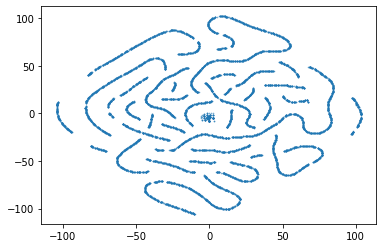

In [34]:
import matplotlib.pyplot as plt


plt.figure()
plt.scatter(X_embedded[:,0],X_embedded[:,1], 
# c=labels,
s=0.5, alpha = 0.5)

plt.show()

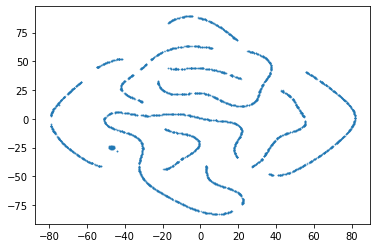

In [38]:
import matplotlib.pyplot as plt


plt.figure()
plt.scatter(X_embedded[:,0],X_embedded[:,1], 
# c=labels,
s=0.5, alpha = 0.5)

plt.show()